<a href="https://colab.research.google.com/github/Msaleemakhtar/Deep-Learning-with-pytorch/blob/main/04_classificationipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with pyTorch

# ***1.Binary Classification ***

In [41]:
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples=n_samples, noise=0.03, random_state=55)

In [42]:
X.shape, y.shape

((1000, 2), (1000,))

In [43]:
X[0:5], y[0:5]

(array([[ 0.84185974, -0.50240901],
        [ 0.11561202, -0.967942  ],
        [ 0.71458802,  0.27456366],
        [ 0.19204725, -0.77725032],
        [-0.96940563,  0.14870034]]),
 array([0, 0, 1, 1, 0]))

In [44]:
import pandas as pd
circle = pd.DataFrame({"X1": X[:,0], "X2":X[:,1], "label":y})

In [45]:
circle.head()

,X1,X2,label
0,0.841860,-0.502409,0
1,0.115612,-0.967942,0
2,0.714588,0.274564,1
3,0.192047,-0.777250,1
4,-0.969406,0.148700,0


In [46]:
circle.X1.value_counts()

X1
 0.841860    1
-0.977034    1
 0.406836    1
-0.927229    1
-0.151870    1
            ..
 0.743345    1
-0.752254    1
-0.975437    1
-0.103319    1
 0.901243    1
Name: count, Length: 1000, dtype: int64

In [47]:
circle.label.value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [48]:
y.shape

(1000,)

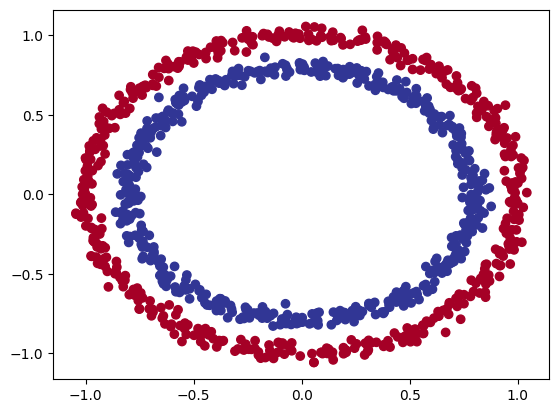

In [49]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
           y =X[:,1],
           c=y,
           cmap= plt.cm.RdYlBu)

In [50]:
import torch


In [51]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.8419, -0.5024],
         [ 0.1156, -0.9679],
         [ 0.7146,  0.2746],
         [ 0.1920, -0.7773],
         [-0.9694,  0.1487]]),
 tensor([0., 0., 1., 1., 0.]))

In [52]:
# split the data for model traing and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=33)

In [53]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [54]:
# device agnostic code
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [55]:
# Building Model
class Model_for_classification(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu =  nn.ReLU()

  def forward(self, x:torch.Tensor)->torch.Tensor:

    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0 = Model_for_classification().to(device)
print(model_0)

Model_for_classification(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [56]:
# replicate Model_for_classification with nn.sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features =2, out_features= 5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

In [57]:
# make predictions with the model
untrained_pred = model_0(X_test.to(device))
print(f"untrained_pred: {len(untrained_pred)}, shape: {untrained_pred.shape}")
print(f"sample test: {len(y_test)}, shape : {y_test.shape}")
untrained_pred[:5], y_test[:5]

untrained_pred: 200, shape: torch.Size([200, 1])
sample test: 200, shape : torch.Size([200])


(tensor([[0.0095],
         [0.0566],
         [0.0205],
         [0.0077],
         [0.0079]], grad_fn=<SliceBackward0>),
 tensor([0., 0., 0., 0., 1.]))

In [58]:
# set up the loss function

loss_fn = nn.BCEWithLogitsLoss() # with sigmoid built_in

# optimizor
optimizor = torch.optim.SGD(params=model_0.parameters(), lr= 0.1)

In [59]:
# setup the evaluation metrics
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/(len(y_true)) *100
  return acc



In [60]:
# Raw model output to predicted labels(logits -> pred probability-> prediction labels)
logits = model_0(X_test.to(device))
logits[:5]

tensor([[0.0095],
        [0.0566],
        [0.0205],
        [0.0077],
        [0.0079]], grad_fn=<SliceBackward0>)

In [61]:
y_pred_probs = torch.sigmoid(logits)
y_pred_probs[:5]

tensor([[0.5024],
        [0.5141],
        [0.5051],
        [0.5019],
        [0.5020]], grad_fn=<SliceBackward0>)

In [62]:
# if the y_pred>= 0.5 = 1 class , if y_pred<=0.5 = close to 0 class
# lets round the y_pred
y_preds= torch.round(y_pred_probs)


In [63]:
# Train and Evaluate the model
torch.manual_seed(55)
 # put the data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


epochs = 1000
for epoch in range(epochs):
  # training
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  # loss function
  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # optimizor for zero grad
  optimizor.zero_grad()
  # back propogation
  loss.backward()
  # optimizor step
  optimizor.step()

  # model testing
  model_0.eval() # put the model under testing
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # set loss function
    test_loss = loss_fn(test_logits, y_test)
    # calculate accuracy
    test_accuracy = accuracy_fn(y_true=y_test, y_pred = test_preds)
  if epoch % 100 == 0:
    print(f"epoch: {epoch}  | loss: {loss}, accuracy: {accuracy}    | test_loss : {test_loss}, test_accuracy:{test_accuracy}")





epoch: 0  | loss: 0.6931021213531494, accuracy: 49.25    | test_loss : 0.6923648118972778, test_accuracy:53.0
epoch: 100  | loss: 0.690441906452179, accuracy: 51.37500000000001    | test_loss : 0.6927395462989807, test_accuracy:50.0
epoch: 200  | loss: 0.6883959174156189, accuracy: 52.87500000000001    | test_loss : 0.6919345259666443, test_accuracy:48.5
epoch: 300  | loss: 0.6852569580078125, accuracy: 54.125    | test_loss : 0.690554678440094, test_accuracy:49.0
epoch: 400  | loss: 0.6805505156517029, accuracy: 54.25    | test_loss : 0.6880607008934021, test_accuracy:49.0
epoch: 500  | loss: 0.6735092401504517, accuracy: 55.875    | test_loss : 0.6833474636077881, test_accuracy:49.5
epoch: 600  | loss: 0.6626584529876709, accuracy: 57.25    | test_loss : 0.675727903842926, test_accuracy:53.0
epoch: 700  | loss: 0.647520124912262, accuracy: 62.375    | test_loss : 0.6637260913848877, test_accuracy:60.0
epoch: 800  | loss: 0.6229128837585449, accuracy: 67.875    | test_loss : 0.6419007

In [64]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [65]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


In [66]:
# Visualize the data
from pathlib import Path
import requests

if Path("helper_functions.py").is_file():
  print("File is already available")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

File is already available


In [67]:
import numpy as np
import matplotlib.pyplot as plt


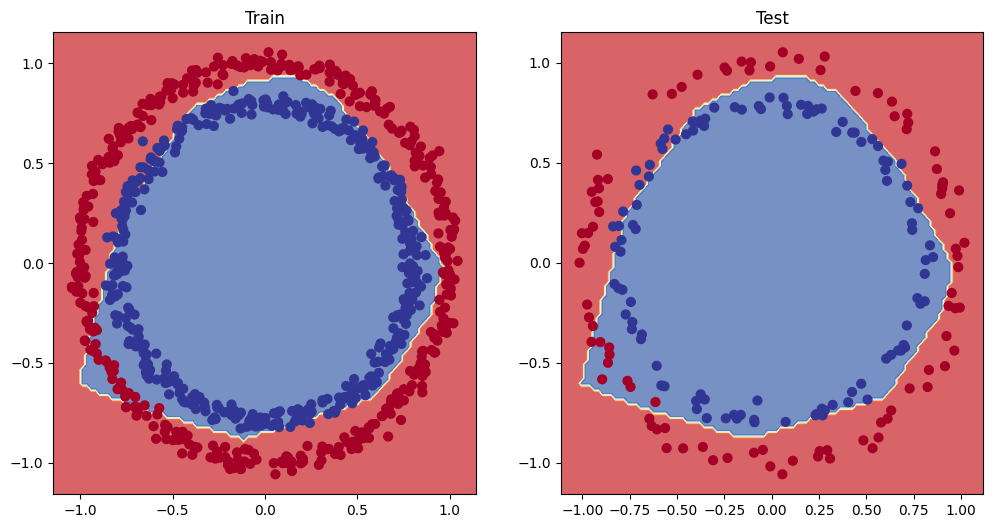

In [68]:

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)



# **2. Mult_class classificati**on

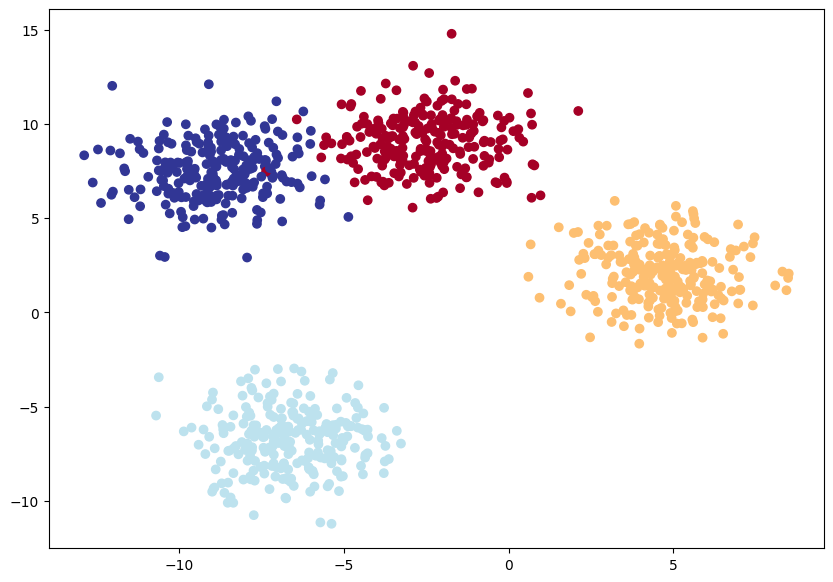

In [69]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_FEATURE = 2
NUM_CLASSES= 4
RANDOM_SEED =42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURE, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)


X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED )

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu )



In [70]:
from torch import nn
class MulticlassModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units=8):
    super().__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.linear_stack(x)

model_1 = MulticlassModel(in_features= NUM_FEATURE, out_features=NUM_CLASSES, hidden_units=10).to(device)

model_1

MulticlassModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [71]:
# perform a single forward pass on data without training
model_1(X_train).to(device)[0:5]

tensor([[-1.3906,  1.3625, -1.5174, -0.4657],
        [-0.1896,  0.6068, -1.9711, -0.0605],
        [ 1.8704, -1.6144,  3.6390,  0.8292],
        [ 1.1566, -0.9027,  2.0951,  0.5331],
        [ 0.0629,  0.3335, -1.2763,  0.0487]], grad_fn=<SliceBackward0>)

In [72]:
model_1(X_train).to(device).shape

torch.Size([800, 4])

In [73]:
X_train.shape

torch.Size([800, 2])

In [74]:
y_train.shape

torch.Size([800])

In [75]:
y_logits = model_1(X_test).to(device)
y_pred_prob = torch.softmax(y_logits, dim=1)
print(y_logits[0:5])
print(y_pred_prob[0:5])

tensor([[-1.3749,  1.3874, -1.7635, -0.4677],
        [ 0.9928, -0.4146, -0.5018,  0.3967],
        [ 1.3728, -1.1823,  3.0054,  0.6362],
        [-1.0208,  1.0018, -0.7730, -0.3140],
        [-0.7080,  1.0382, -2.5016, -0.2576]], grad_fn=<SliceBackward0>)
tensor([[0.0500, 0.7921, 0.0339, 0.1239],
        [0.4950, 0.1212, 0.1111, 0.2727],
        [0.1498, 0.0116, 0.7668, 0.0717],
        [0.0843, 0.6369, 0.1080, 0.1709],
        [0.1181, 0.6770, 0.0196, 0.1853]], grad_fn=<SliceBackward0>)


In [76]:
torch.sum(y_pred_prob[0])

tensor(1., grad_fn=<SumBackward0>)

In [77]:
print(y_pred_prob[2])


tensor([0.1498, 0.0116, 0.7668, 0.0717], grad_fn=<SelectBackward0>)


In [78]:

torch.argmax(y_pred_prob[2])

tensor(2)

In [79]:
# setup the loss function and optimizor
loss_fn = nn.CrossEntropyLoss()
optimizor = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [84]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


y_train=y_train.long()
y_test=y_test.long()

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizor.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizor.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.88333, Acc: 53.00% | Test Loss: 0.40145, Test Acc: 89.50%
Epoch: 100 | Loss: 0.03262, Acc: 99.00% | Test Loss: 0.02368, Test Acc: 99.50%
Epoch: 200 | Loss: 0.02805, Acc: 99.12% | Test Loss: 0.01816, Test Acc: 99.50%
Epoch: 300 | Loss: 0.02666, Acc: 99.12% | Test Loss: 0.01629, Test Acc: 99.50%
Epoch: 400 | Loss: 0.02593, Acc: 99.25% | Test Loss: 0.01530, Test Acc: 99.50%
Epoch: 500 | Loss: 0.02543, Acc: 99.25% | Test Loss: 0.01465, Test Acc: 99.50%
Epoch: 600 | Loss: 0.02504, Acc: 99.25% | Test Loss: 0.01415, Test Acc: 99.50%
Epoch: 700 | Loss: 0.02470, Acc: 99.25% | Test Loss: 0.01375, Test Acc: 99.50%
Epoch: 800 | Loss: 0.02440, Acc: 99.25% | Test Loss: 0.01340, Test Acc: 99.50%
Epoch: 900 | Loss: 0.02412, Acc: 99.38% | Test Loss: 0.01308, Test Acc: 99.50%


In [85]:
# Model evaluation
model_0.eval()
with torch.inference_mode():
  y_logits = model_1(X_train)

# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim = 1)
# Turn prediction probabilities into prediction labels
y_pred =  y_pred_probs.argmax(dim=1)

print(f"predictions : {y_preds[0:5]}\nlabels : {y_test[0:5]}")

predictions : tensor([0., 1., 0., 0., 0.], grad_fn=<SliceBackward0>)
labels : tensor([1, 3, 2, 1, 0])


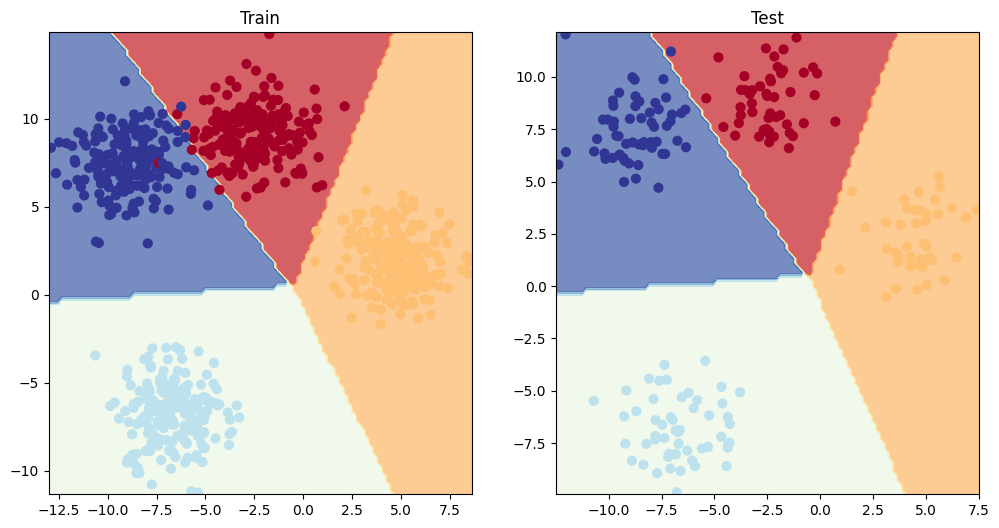

In [86]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)